<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/CSHA2021/tutorials/Computational%20Neuroscience/network_model/4.2_Attractor_Networks/Attractor_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attractor Network

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


def show_img(x, size_w, size_h):
    x = (x-np.min(x))
    x = x/np.max(x)
    img = np.zeros([size_w, size_h,3])
    img[:,:,0] = x.reshape([size_w, size_h])
    img[:,:, 1] = x.reshape([size_w, size_h])
    img[:,:, 2] = x.reshape([size_w, size_h])
    plt.imshow(img)
    plt.show(block=False)
    plt.pause(1)
    plt.close()


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])/255


### Hopfield Network

Here we have a network with $N$ neurons, the $i$th neuron state is given by:

$$ 𝑥_𝑖, ∀𝑖∈{1,2,…,𝑁}, 𝑥_𝑖=±n$$.

The memory pattern is $\xi_i^\mu$, where $ ∀ i∈{1,2,…,𝑁}$, $\mu∈{1,2,…,𝑃}$ and $\xi_i^\mu  = ±1$.

Hebbian learning rule

$$
w_{i, j}= \begin{cases}\frac{1}{P} \sum_{\mu=1}^{P} \xi_{i} \xi_{j}, & i \neq j ; \\ 0, & i=j .\end{cases}
$$


We start with an illustrative example of a Hopfield Network. One input image should first be stored and then be retrieved.

The input image is:

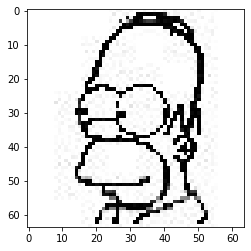

In [52]:
# load img as pattern
img = rgb2gray(mpimg.imread('./hopfield.jpg'))
size_w, size_h = img.shape
xi = (img.reshape([size_w * size_h, 1]) - 0.5) * 2

show_img(xi,size_w,size_h)

The weight matrix weight is the outer product of this memory $\xi$.

Can the image be restored when added noise? 

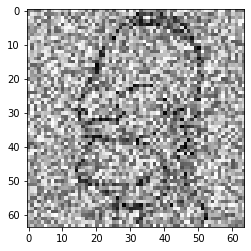

In [53]:

# generate weight using Hebb
weight = xi.T*xi
weight = weight - np.diag(weight)

# add noise to input xo (x)
A_noise = 2 #noise levels
noise =  A_noise * np.random.rand(size_w * size_h, 1) * 2 - 1
x = xi + noise
show_img(x, size_w, size_h)


The dynamics of the network is given by:

$$
\begin{aligned}
&h_{i}(t+1)=1 / N \sum_{j=1}^{N} w_{i, j} x_{j}(t) \\
&x_{i}(t+1)=\operatorname{sign}\left(h_{i}(t+1)\right)
\end{aligned}
$$



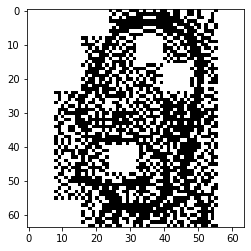

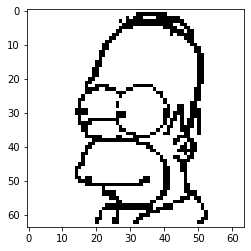

In [54]:
### synchronous update

for t in range(2):
  h = weight@x / x.shape[0]
  x = np.sign(h)
  show_img(x, size_w, size_h)

Can the original image be restored if $2/3$ of the pixels are masked out? The masked image is:

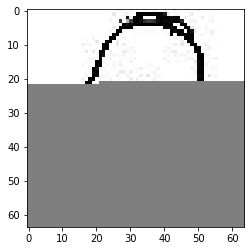

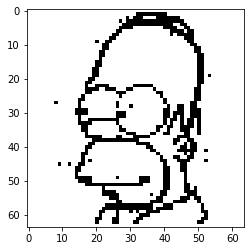

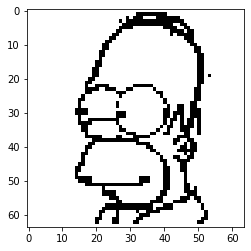

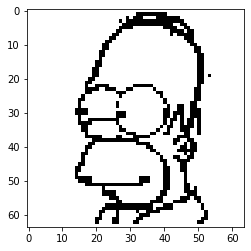

In [56]:
### masked xi --> input x0 (x)

x = np.zeros([size_w * size_h, 1])
x[:int(size_w * size_h / 3)] = xi[:int(size_w * size_h / 3)]
show_img(x, size_w, size_h)

### synchronous update
for t in range(3):
    h = weight@x
    x = np.sign(h)
    show_img(x, size_w, size_h)


What happens if we store more than one pattern? The weight matrix is then built from the sum of outer products of three stored patterns (three input images):

### Continuous Attractor Neural Network (CANN) 


Here we show the implementation of the paper:

- Si Wu, Kosuke Hamaguchi, and Shun-ichi Amari. "Dynamics and computation
  of continuous attractors." Neural computation 20.4 (2008): 994-1025.

The mathematical equation of the Continuous-attractor Neural Network (CANN) is given by:

$$\tau \frac{du(x,t)}{dt} = -u(x,t) + \rho \int dx' J(x,x') r(x',t)+I_{ext}$$

$$r(x,t) = \frac{u(x,t)^2}{1 + k \rho \int dx' u(x',t)^2}$$

$$J(x,x') = \frac{1}{\sqrt{2\pi}a}\exp(-\frac{|x-x'|^2}{2a^2})$$

$$I_{ext} = A\exp\left[-\frac{|x-z(t)|^2}{4a^2}\right]$$

In [59]:
pip install -U brainpy-simulator

     |████████████████████████████████| 126 kB 4.1 MB/s 
  Created wheel for brainpy-simulator: filename=brainpy_simulator-1.0.2-py3-none-any.whl size=152106 sha256=894073e719fc478696647b2bca32c5380e537c0c17a9ed6a64102f5f22553182
  Stored in directory: /root/.cache/pip/wheels/ec/1c/3f/e33093b69bc03ff9b2742480ec6126ddef875ba4f6d3699659
Successfully built brainpy-simulator


In [66]:
import numpy as np
import brainpy as bp


class CANN1D(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(u, t, conn, k, tau, Iext):
    r1 = np.square(u)
    r2 = 1 + k * np.sum(r1)
    r = r1 / r2
    Irec = np.dot(conn, r)
    du = (-u + Iext + Irec) / tau
    return du    
  
  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4.,
                z_min=-np.pi, z_max=np.pi, **kwargs):
    # parameters
    self.tau = tau  # The synaptic time constant
    self.k = k  # Degree of the rescaled inhibition
    self.a = a  # Half-width of the range of excitatory connections
    self.A = A  # Magnitude of the external input
    self.J0 = J0  # maximum connection value

    # feature space
    self.z_min = z_min 
    self.z_max = z_max 
    self.z_range = z_max - z_min
    self.x = np.linspace(z_min, z_max, num)  # The encoded feature values

    # variables
    self.u = np.zeros(num) # variable u
    self.input = np.zeros(num) # external input

    # The connection matrix
    self.conn_mat = self.make_conn(self.x)

    self.int_u = bp.odeint(f=self.derivative, method='rk4', dt=0.05)
    
    super(CANN1D, self).__init__(size=num, **kwargs)

    self.rho = num / self.z_range  # The neural density
    self.dx = self.z_range / num  # The stimulus density

  def dist(self, d):
    # distance
    d = np.remainder(d, self.z_range)
    d = np.where(d > 0.5 * self.z_range, d-self.z_range, d)
    return d

  def make_conn(self, x):
    assert np.ndim(x) == 1
    # connection 
    x_left = np.reshape(x, (-1,1))
    x_right = np.repeat(x.reshape((1,-1)), len(x), axis=0)
    d = self.dist(x_left - x_right)
    Jxx = self.J0 * np.exp(-0.5 * np.square(d/self.a))
    return Jxx

  def get_stimulus_by_pos(self, pos):
    # I_ext
    return self.A * np.exp(-0.25 * np.square(self.dist(self.x - pos) / self.a))

  def update(self, _t):
    self.u = self.int_u(self.u, _t, self.conn_mat, self.k, self.tau, self.input)
    self.input[:] = 0.


### Population coding

In [67]:
%%capture
# supress output

cann = CANN1D(num=512, k=0.1, monitors=['u'])

I1 = cann.get_stimulus_by_pos(0.)
Iext, duration = bp.inputs.constant_current([(0., 1.), (I1, 8.), (0., 8.)])
cann.run(duration=duration, inputs=('input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x, 'legend': 'u'},
                    {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
    frame_step=1,
    frame_delay=50,
    show=True,
    save_path='./CANN-encoding.gif'
)


TypeError: ignored

Note: The contents in the markdown cells are cached, so they might not represent the latest result. 

To force the evaluation of the markdown cell:

1. Change the content of the cell randomly, then run the cell.
2. Revert the changes, then rerun the cell.

<img src="./CANN-encoding.gif">

### Template matching

The CANN can perform efficient population decoding by achieving template-matching. 

In [68]:
%%capture
# supress output

cann = CANN1D(num=512, k=8.1, monitors=['u'])

# Iext by position
dur1, dur2, dur3 = 10., 30., 0.
num1 = int(dur1 / bp.backend.get_dt())
num2 = int(dur2 / bp.backend.get_dt())
num3 = int(dur3 / bp.backend.get_dt())
Iext = np.zeros((num1 + num2 + num3,) + cann.size)
Iext[:num1] = cann.get_stimulus_by_pos(2)
Iext[num1:num1 + num2] = cann.get_stimulus_by_pos(0.)
Iext[num1:num1 + num2] += 0.1 * cann.A * np.random.randn(num2, *cann.size)
cann.run(duration=dur1 + dur2 + dur3, inputs=('input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x, 'legend': 'u'},
                    {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
    frame_step=5,
    frame_delay=50,
    show=True,
    save_path='./CANN-decoding.gif'
)

TypeError: ignored

<img src="./CANN-decoding.gif">

### Smooth tracking

The CANN can track moving stimulus. 

In [69]:
%%capture
# supress output

cann = CANN1D(num=512, k=8.1, monitors=['u'])

# Iext by position
dur1, dur2, dur3 = 20., 20., 20.
num1 = int(dur1 / bp.backend.get_dt())
num2 = int(dur2 / bp.backend.get_dt())
num3 = int(dur3 / bp.backend.get_dt())
position = np.zeros(num1 + num2 + num3)
position[num1: num1 + num2] = np.linspace(0., 12., num2)
position[num1 + num2:] = 12.
position = position.reshape((-1, 1))
Iext = cann.get_stimulus_by_pos(position)

cann.run(duration=dur1 + dur2 + dur3, inputs=('input', Iext))

bp.visualize.animate_1D(
    dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x, 'legend': 'u'},
                    {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
    frame_step=5,
    frame_delay=50,
    show=True,
    save_path='./CANN-tracking.gif'
)

TypeError: ignored

<img src="./CANN-tracking.gif">